In [125]:
import re
from os import path
import numpy as np
import pandas as pd
import zipfile
import nltk
import sys
# import wget
import time
from sklearn.model_selection import train_test_split
nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

import keras
import tensorflow as tf
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers.embeddings import Embedding
from keras import optimizers
from keras.layers import SimpleRNN,Dense,LSTM,Dropout,GRU,Bidirectional
from keras import regularizers


[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [127]:
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', -1)
np.set_printoptions(threshold=sys.maxsize)

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:4: FutureWarning: Passing a negative integer is deprecated in version 1.0 and will not be supported in future version. Instead, use None to not limit the column width.
  after removing the cwd from sys.path.


In [128]:
# Only include classes specified in accepted_class 
def clean_class(df,accepted_class:np.ndarray):
   # accepted_class = np.array([1, 0, -1])
    decode_map = {0: 0, 2: 2, 1: 1,-1:-1, '0': 0, '2': 2, '1': 1,'-1':-1}
    df['target'].map(decode_map)
    df = df.loc[df['target'].isin(accepted_class)]
    df.astype({'target': 'int'}).dtypes
    return df

In [129]:
def preprocess_text(text):
    wordnet_lemmatizer = WordNetLemmatizer()
    text = text.lower()
    # removing tags and text inside tags Eg: <a> , <e>
    text = re.sub('<[^>]*>','',text)
    # removing Http Links
    text = re.sub('https?:\S+','',text)
    # removing special characters
    text = re.sub('[^\w\s]','',text)
   # text = re.sub('[0-9]+','',text)
    text = ' '.join(word for word in text.split() if word not in stopwords.words('english')) 
    #text = 
    return text.strip()

In [130]:
%%time
def load_glove_embeddings():
#     if not path.exists('glove.twitter.27B.zip'):
#         print('Please wait while the Global Vector Word Embeddings are being downloaded.')
#         !wget 'http://nlp.stanford.edu/data/glove.twitter.27B.zip'
#         #unzip glove*.zip
#     glove = zipfile.ZipFile('glove.twitter.27B.zip')
    embeddings = {}
    with open('../input/glovetwitter/glove.twitter.27B.200d.txt','r') as file:
        for line in file:
#             line = line.decode('utf-8')
            words = line.split()
            word = words[0]
            word_vectors = np.asarray(words[1:], dtype='float32')
            embeddings[word] = word_vectors
    return embeddings
word_embeddings = load_glove_embeddings()

CPU times: user 2min 1s, sys: 2.76 s, total: 2min 4s
Wall time: 2min 2s


In [131]:
def generate_embeddings():
    vocab_size = len(tokenizer.word_index)+1
    embedding_size = 200
    embedding_matrix = np.zeros((vocab_size, embedding_size))
    for word,index in tokenizer.word_index.items():
        vector = word_embeddings.get(word)
        if vector is not None:
            embedding_matrix[index] = vector
    return embedding_matrix

In [7]:
# def read_input():
#     if not path.exists('training-Obama-Romney-tweets.rar'):
#         print('Downloading training-Obama-Romney-tweets.rar')
#         wget.download('https://www.cs.uic.edu/~liub/teach/cs583-fall-20/training-Obama-Romney-tweets.rar')
#     rar = rarfile.RarFile('training-Obama-Romney-tweets.rar')
#     input =rar.open('training-Obama-Romney-tweets.xlsx')
#     return input

In [141]:
sheets = [0,1]
input_data = pd.read_excel('../input/cs583-dataset/training-Obama-Romney-tweets.xlsx',sheet_name=sheets)

In [142]:
def clean_excel(data:pd.DataFrame):
    # Preprocessing Training data
    # Removing first row as it has only information about class value mappings
    data = data[1:]
    data.rename(columns={'Unnamed: 4': 'target'}, inplace=True)
    # Dropping empty columns
    data.dropna(how='all', inplace=True, axis=1)
    #Dropping date and time
    data.dropna(subset=['Anootated tweet','target'] ,inplace=True, axis=0)
    return data

In [143]:
data_clean = pd.DataFrame()
for i in sheets:
    data_temp = clean_excel(input_data[i])
    data_clean=data_clean.append(data_temp)

/opt/conda/lib/python3.7/site-packages/pandas/core/frame.py:4308: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':
/opt/conda/lib/python3.7/site-packages/pandas/core/fra

In [144]:
data_clean = clean_class(data_clean,np.array([1,0,-1]))

In [145]:
%%time
data_clean['Anootated tweet']=data_clean['Anootated tweet'].apply(lambda x: preprocess_text(x))

CPU times: user 24.3 s, sys: 2.4 s, total: 26.7 s
Wall time: 26.7 s


In [146]:
data_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 11118 entries, 1 to 7200
Data columns (total 4 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   date             11114 non-null  object
 1   time             11111 non-null  object
 2   Anootated tweet  11118 non-null  object
 3   target           11118 non-null  object
dtypes: object(4)
memory usage: 434.3+ KB


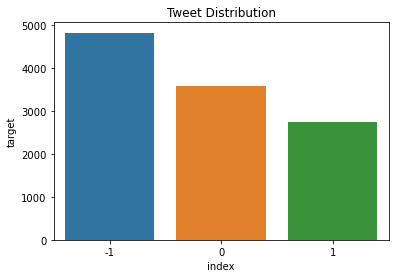

In [147]:
target_count = data_clean['target'].value_counts().reset_index()
ax = sns.barplot(x=target_count['index'], y=target_count['target'])
plt.title("Tweet Distribution")
plt.show()

In [150]:
#convert target to categorical 
labels=pd.get_dummies(data_clean['target'])

In [151]:
data_clean.head()

,date,time,Anootated tweet,target
1,2012-10-16 00:00:00,10:28:53-05:00,kirkpatrick wore baseball cap embroidered barack obamas signature hangdog look jason segel courier journal,0
3,2012-10-16 00:00:00,10:04:30-05:00,obama debates cracker ass cracker tonight tuned teamobama,1
5,2012-10-16 00:00:00,09:50:08-05:00,hollivan hereistheanswer youre missing point im afraid understand bigger picture dont care obama elected,0
7,2012-10-16 00:00:00,10:00:16-05:00,raised democrat left party years ago 1980 lifetime never seen president divide country like obama,-1
8,2012-10-16 00:00:00,09:48:07-05:00,obama camp cant afford lower expectations tonights debate president must give strong performance,0


In [152]:
#Splitting the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(data_clean['Anootated tweet'],labels, test_size=0.2, stratify=data_clean['target'])

In [153]:
tokenizer = Tokenizer(num_words=20000,oov_token='<OOV>')
tokenizer.fit_on_texts(X_train)

In [154]:
word_embedding_matrix = generate_embeddings()

In [155]:
word_embedding_matrix.shape

(14763, 200)

In [156]:
X_train_processed = tokenizer.texts_to_sequences(X_train)
X_train_processed = pad_sequences(X_train_processed, padding='post', maxlen=50,truncating='pre')

In [157]:
X_test_processed = tokenizer.texts_to_sequences(X_test)
X_test_processed = pad_sequences(X_test_processed, padding='post', maxlen=50,truncating='pre')

In [158]:
model = Sequential()
embedding_layer = Embedding(len(tokenizer.word_index)+1, 200, weights=[word_embedding_matrix], input_length=50,trainable = False,mask_zero=True)
model.add(embedding_layer)

In [159]:
model.add(LSTM(200,kernel_regularizer =regularizers.l1_l2(l1=0.01, l2=0.01)))

In [160]:
model.add(Dropout(0.5))

model.add(Dense(3, activation='softmax'))
opt = tf.keras.optimizers.Adam(learning_rate=0.001)
model.compile(opt, loss='categorical_crossentropy', metrics=['accuracy'])
print(model.summary())

Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_8 (Embedding)      (None, 50, 200)           2952600   
_________________________________________________________________
lstm_7 (LSTM)                (None, 200)               320800    
_________________________________________________________________
dropout_9 (Dropout)          (None, 200)               0         
_________________________________________________________________
dense_15 (Dense)             (None, 3)                 603       
Total params: 3,274,003
Trainable params: 321,403
Non-trainable params: 2,952,600
_________________________________________________________________
None


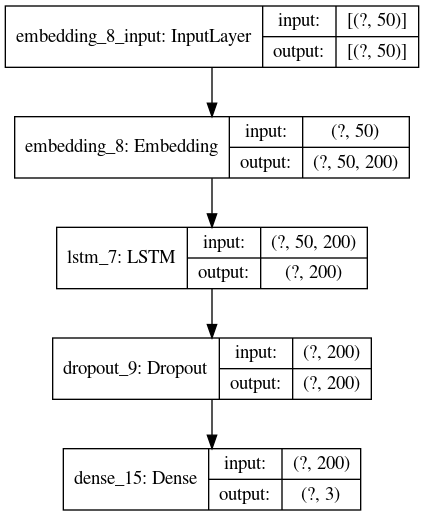

In [161]:
import pydot
dot_img_file = 'model_1.png'
tf.keras.utils.plot_model(model, to_file=dot_img_file, show_shapes=True)

In [162]:
model_history = model.fit(X_train_processed, y_train, batch_size=100, epochs=20, verbose=1,validation_split = 0.2)

Epoch 1/20
72/72 [==============================] - 15s 214ms/step - loss: 25.8515 - accuracy: 0.4547 - val_loss: 2.6073 - val_accuracy: 0.4519
Epoch 2/20
72/72 [==============================] - 13s 177ms/step - loss: 1.5557 - accuracy: 0.4682 - val_loss: 1.3099 - val_accuracy: 0.4497
Epoch 3/20
72/72 [==============================] - 13s 186ms/step - loss: 1.2646 - accuracy: 0.4992 - val_loss: 1.2658 - val_accuracy: 0.5143
Epoch 4/20
72/72 [==============================] - 13s 179ms/step - loss: 1.2397 - accuracy: 0.5082 - val_loss: 1.2459 - val_accuracy: 0.5121
Epoch 5/20
72/72 [==============================] - 13s 184ms/step - loss: 1.2261 - accuracy: 0.5197 - val_loss: 1.2390 - val_accuracy: 0.5160
Epoch 6/20
72/72 [==============================] - 14s 188ms/step - loss: 1.2172 - accuracy: 0.5351 - val_loss: 1.2364 - val_accuracy: 0.5289
Epoch 7/20
72/72 [==============================] - 13s 181ms/step - loss: 1.2088 - accuracy: 0.5476 - val_loss: 1.2162 - val_accuracy: 0.549

In [163]:
model.evaluate(X_test_processed,y_test)

70/70 [==============================] - 2s 35ms/step - loss: 1.2198 - accuracy: 0.5315


[1.2197643518447876, 0.5314748287200928]

In [164]:
data_clean.head()

,date,time,Anootated tweet,target
1,2012-10-16 00:00:00,10:28:53-05:00,kirkpatrick wore baseball cap embroidered barack obamas signature hangdog look jason segel courier journal,0
3,2012-10-16 00:00:00,10:04:30-05:00,obama debates cracker ass cracker tonight tuned teamobama,1
5,2012-10-16 00:00:00,09:50:08-05:00,hollivan hereistheanswer youre missing point im afraid understand bigger picture dont care obama elected,0
7,2012-10-16 00:00:00,10:00:16-05:00,raised democrat left party years ago 1980 lifetime never seen president divide country like obama,-1
8,2012-10-16 00:00:00,09:48:07-05:00,obama camp cant afford lower expectations tonights debate president must give strong performance,0


In [95]:
model.predict(X_test_processed[0].reshape(1,50))

array([[0.5976462 , 0.5082791 , 0.47754788]], dtype=float32)

In [108]:
X_test_processed

array([[    1,     1,     2,   171,   180,   697,   109,    57,   381,
            9,     3,   562,   143,  1138,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0],
       [    3,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0],
       [    3,     1,  1112, 12983,  5147,  1310,     1,     8,    42,
         4023,  1112,     1,  1897,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,    

In [100]:
np.reshape(X_train_processed,(1,50))

ValueError: cannot reshape array of size 444700 into shape (1,50)

In [109]:
for x in X_test_processed :
    print(x.shape)

(50,)
(50,)
(50,)
(50,)
(50,)
(50,)
(50,)
(50,)
(50,)
(50,)
(50,)
(50,)
(50,)
(50,)
(50,)
(50,)
(50,)
(50,)
(50,)
(50,)
(50,)
(50,)
(50,)
(50,)
(50,)
(50,)
(50,)
(50,)
(50,)
(50,)
(50,)
(50,)
(50,)
(50,)
(50,)
(50,)
(50,)
(50,)
(50,)
(50,)
(50,)
(50,)
(50,)
(50,)
(50,)
(50,)
(50,)
(50,)
(50,)
(50,)
(50,)
(50,)
(50,)
(50,)
(50,)
(50,)
(50,)
(50,)
(50,)
(50,)
(50,)
(50,)
(50,)
(50,)
(50,)
(50,)
(50,)
(50,)
(50,)
(50,)
(50,)
(50,)
(50,)
(50,)
(50,)
(50,)
(50,)
(50,)
(50,)
(50,)
(50,)
(50,)
(50,)
(50,)
(50,)
(50,)
(50,)
(50,)
(50,)
(50,)
(50,)
(50,)
(50,)
(50,)
(50,)
(50,)
(50,)
(50,)
(50,)
(50,)
(50,)
(50,)
(50,)
(50,)
(50,)
(50,)
(50,)
(50,)
(50,)
(50,)
(50,)
(50,)
(50,)
(50,)
(50,)
(50,)
(50,)
(50,)
(50,)
(50,)
(50,)
(50,)
(50,)
(50,)
(50,)
(50,)
(50,)
(50,)
(50,)
(50,)
(50,)
(50,)
(50,)
(50,)
(50,)
(50,)
(50,)
(50,)
(50,)
(50,)
(50,)
(50,)
(50,)
(50,)
(50,)
(50,)
(50,)
(50,)
(50,)
(50,)
(50,)
(50,)
(50,)
(50,)
(50,)
(50,)
(50,)
(50,)
(50,)
(50,)
(50,)
(50,)
(50,)
(50,)
(50,)
(50,)
(50,

(50,)
(50,)
(50,)
(50,)
(50,)
(50,)
(50,)
(50,)
(50,)
(50,)
(50,)
(50,)
(50,)
(50,)
(50,)
(50,)
(50,)
(50,)
(50,)
(50,)
(50,)
(50,)
(50,)
(50,)
(50,)
(50,)
(50,)
(50,)
(50,)
(50,)
(50,)
(50,)
(50,)
(50,)
(50,)
(50,)
(50,)
(50,)
(50,)
(50,)
(50,)
(50,)
(50,)
(50,)
(50,)
(50,)
(50,)
(50,)
(50,)
(50,)
(50,)
(50,)
(50,)
(50,)
(50,)
(50,)
(50,)
(50,)
(50,)
(50,)
(50,)
(50,)
(50,)
(50,)
(50,)
(50,)
(50,)
(50,)
(50,)
(50,)
(50,)
(50,)
(50,)
(50,)
(50,)
(50,)
(50,)
(50,)
(50,)
(50,)
(50,)
(50,)
(50,)
(50,)
(50,)
(50,)
(50,)
(50,)
(50,)
(50,)
(50,)
(50,)
(50,)
(50,)
(50,)
(50,)
(50,)
(50,)
(50,)
(50,)
(50,)
(50,)
(50,)
(50,)
(50,)
(50,)
(50,)
(50,)
(50,)
(50,)
(50,)
(50,)
(50,)


In [80]:
pd.get_dummies(y_train)

,-1,0,1
5816,1,0,0
4798,0,0,1
2214,0,1,0
5152,0,1,0
2863,0,1,0
5398,1,0,0
6910,1,0,0
5208,1,0,0
5642,0,1,0
3587,1,0,0


KeyboardInterrupt: 